In [1]:
from __future__ import annotations

from collections import OrderedDict
from pathlib import Path

import hist
import numpy as np
import uproot

from HH4b import plotting
from HH4b.hh_vars import data_key
from HH4b.utils import ShapeVar

In [2]:
%load_ext autoreload
%autoreload 2

In [4]:
MAIN_DIR = Path("/home/users/woodson/HH4b")

vbf = True
# k2v0sig = True
mreg = True

plot_dir = MAIN_DIR / "plots/PostFit/run3-bdtv13-glopartv2-june2-rerun-bdt-zbb-sf-384-unblind"
plot_dir.mkdir(exist_ok=True, parents=True)

regions = "all"

In [6]:
cards_dir = "run3-bdtv13-glopartv2-june2-rerun-bdt-zbb-sf-384-unblind-all-sig"
file = uproot.open(f"{MAIN_DIR}/src/HH4b/cards/{cards_dir}/FitShapesB.root")

In [11]:
# (name in templates -> name in cards)
hist_label_map_inverse = OrderedDict(
    [
        ("qcd", "CMS_bbbb_hadronic_qcd_datadriven"),
        ("zz", "ZZ"),
        ("nozzdiboson", "other_diboson"),
        ("vjets", "vjets"),
        ("ttbar", "ttbar"),
        ("vhtobb", "VH_hbb"),
        ("tthtobb", "ttH_hbb"),
        ("data", "data_obs"),
        ("hh4b", "ggHH_kl_1_kt_1_13p6TeV_hbbhbb"),
        ("vbfhh4b", "qqHH_CV_1_C2V_1_kl_1_13p6TeV_hbbhbb"),
    ]
)

hist_label_map = {val: key for key, val in hist_label_map_inverse.items()}
samples = list(hist_label_map.values())

fit_shape_var_msd = ShapeVar(
    "H2Msd",
    r"$m^{j2}_\mathrm{SD}$ (GeV)",
    [16, 60, 220],
    reg=True,
    blind_window=[110, 140],
)

fit_shape_var_mreg = ShapeVar(
    "H2PNetMass",
    r"$m^{j2}_\mathrm{reg}$ (GeV)",
    [16, 60, 220],
    reg=True,
    blind_window=[110, 140],
)
shape_vars = [fit_shape_var_msd] if not mreg else [fit_shape_var_mreg]

In [12]:
shapes = {
    # "prefit": "Pre-Fit",
    "postfit": "B-only Post-Fit",
}

selection_regions_labels = {
    "passbin1": "Pass Bin1",
    "passbin2": "Pass Bin2",
    "passbin3": "Pass Bin3",
    "passvbf": "Pass VBF",
    "fail": "Fail",
}

In [13]:
if regions == "all":
    signal_regions = ["passbin1", "passbin2", "passbin3", "passvbf"]
else:
    signal_regions = [regions]

bins = [*signal_regions, "fail"]
selection_regions = {key: selection_regions_labels[key] for key in bins}

In [14]:
# build histograms
hists = {}
bgerrs = {}
data_errs = {}
for shape in shapes:
    hists[shape] = {
        region: hist.Hist(
            hist.axis.StrCategory(samples, name="Sample"),
            *[shape_var.axis for shape_var in shape_vars],
            storage="double",
        )
        for region in selection_regions
    }

    bgerrs[shape] = {}
    data_errs[shape] = {}

    for region in selection_regions:
        h = hists[shape][region]
        templates = file[f"{region}_{shape}"]
        for key, file_key in hist_label_map_inverse.items():
            if key != data_key:
                if file_key not in templates:
                    print(f"No {key} in {region}")
                    continue

                data_key_index = np.where(np.array(list(h.axes[0])) == key)[0][0]
                h.view(flow=False)[data_key_index, :] = templates[file_key].values()

        data_key_index = np.where(np.array(list(h.axes[0])) == data_key)[0][0]
        h.view(flow=False)[data_key_index, :] = np.nan_to_num(
            templates[hist_label_map_inverse[data_key]].values()
        )
        # bgerrs[shape][region] = templates["TotalBkg"].errors()
        bgerrs[shape][region] = templates["CMS_bbbb_hadronic_qcd_datadriven"].errors()

No nozzdiboson in passbin1
No nozzdiboson in passbin2
No hh4b in fail
No vbfhh4b in fail


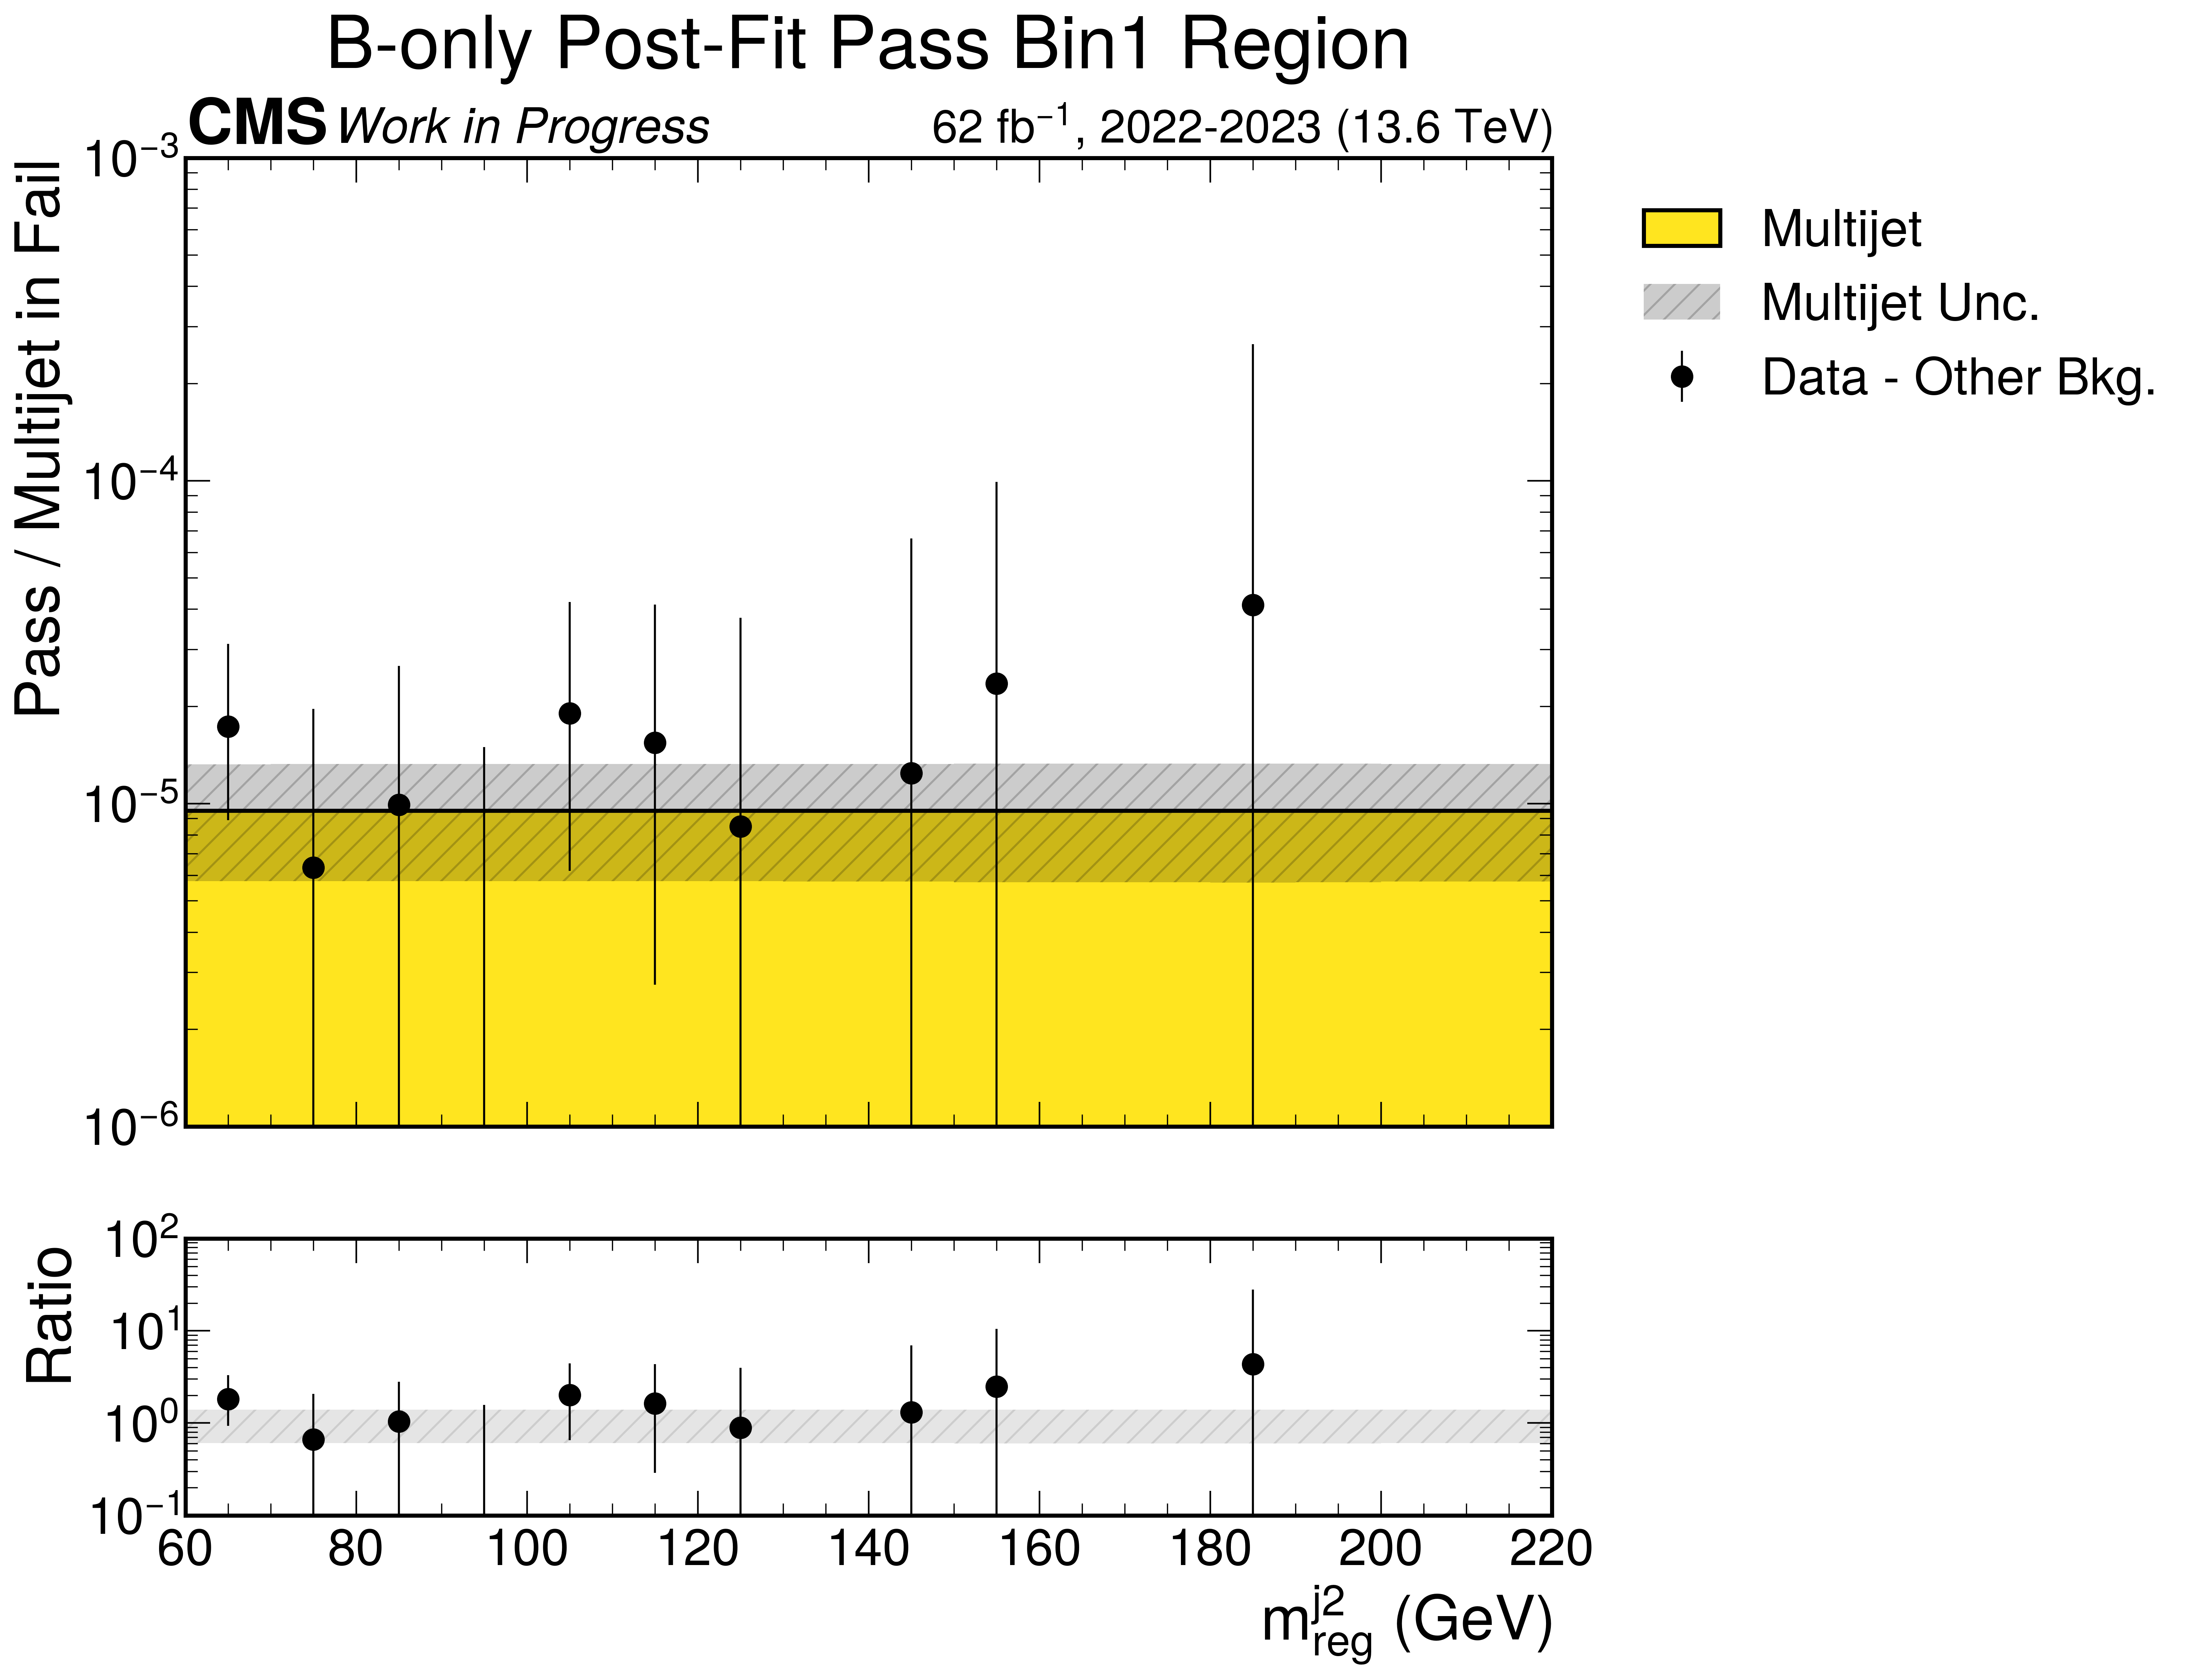

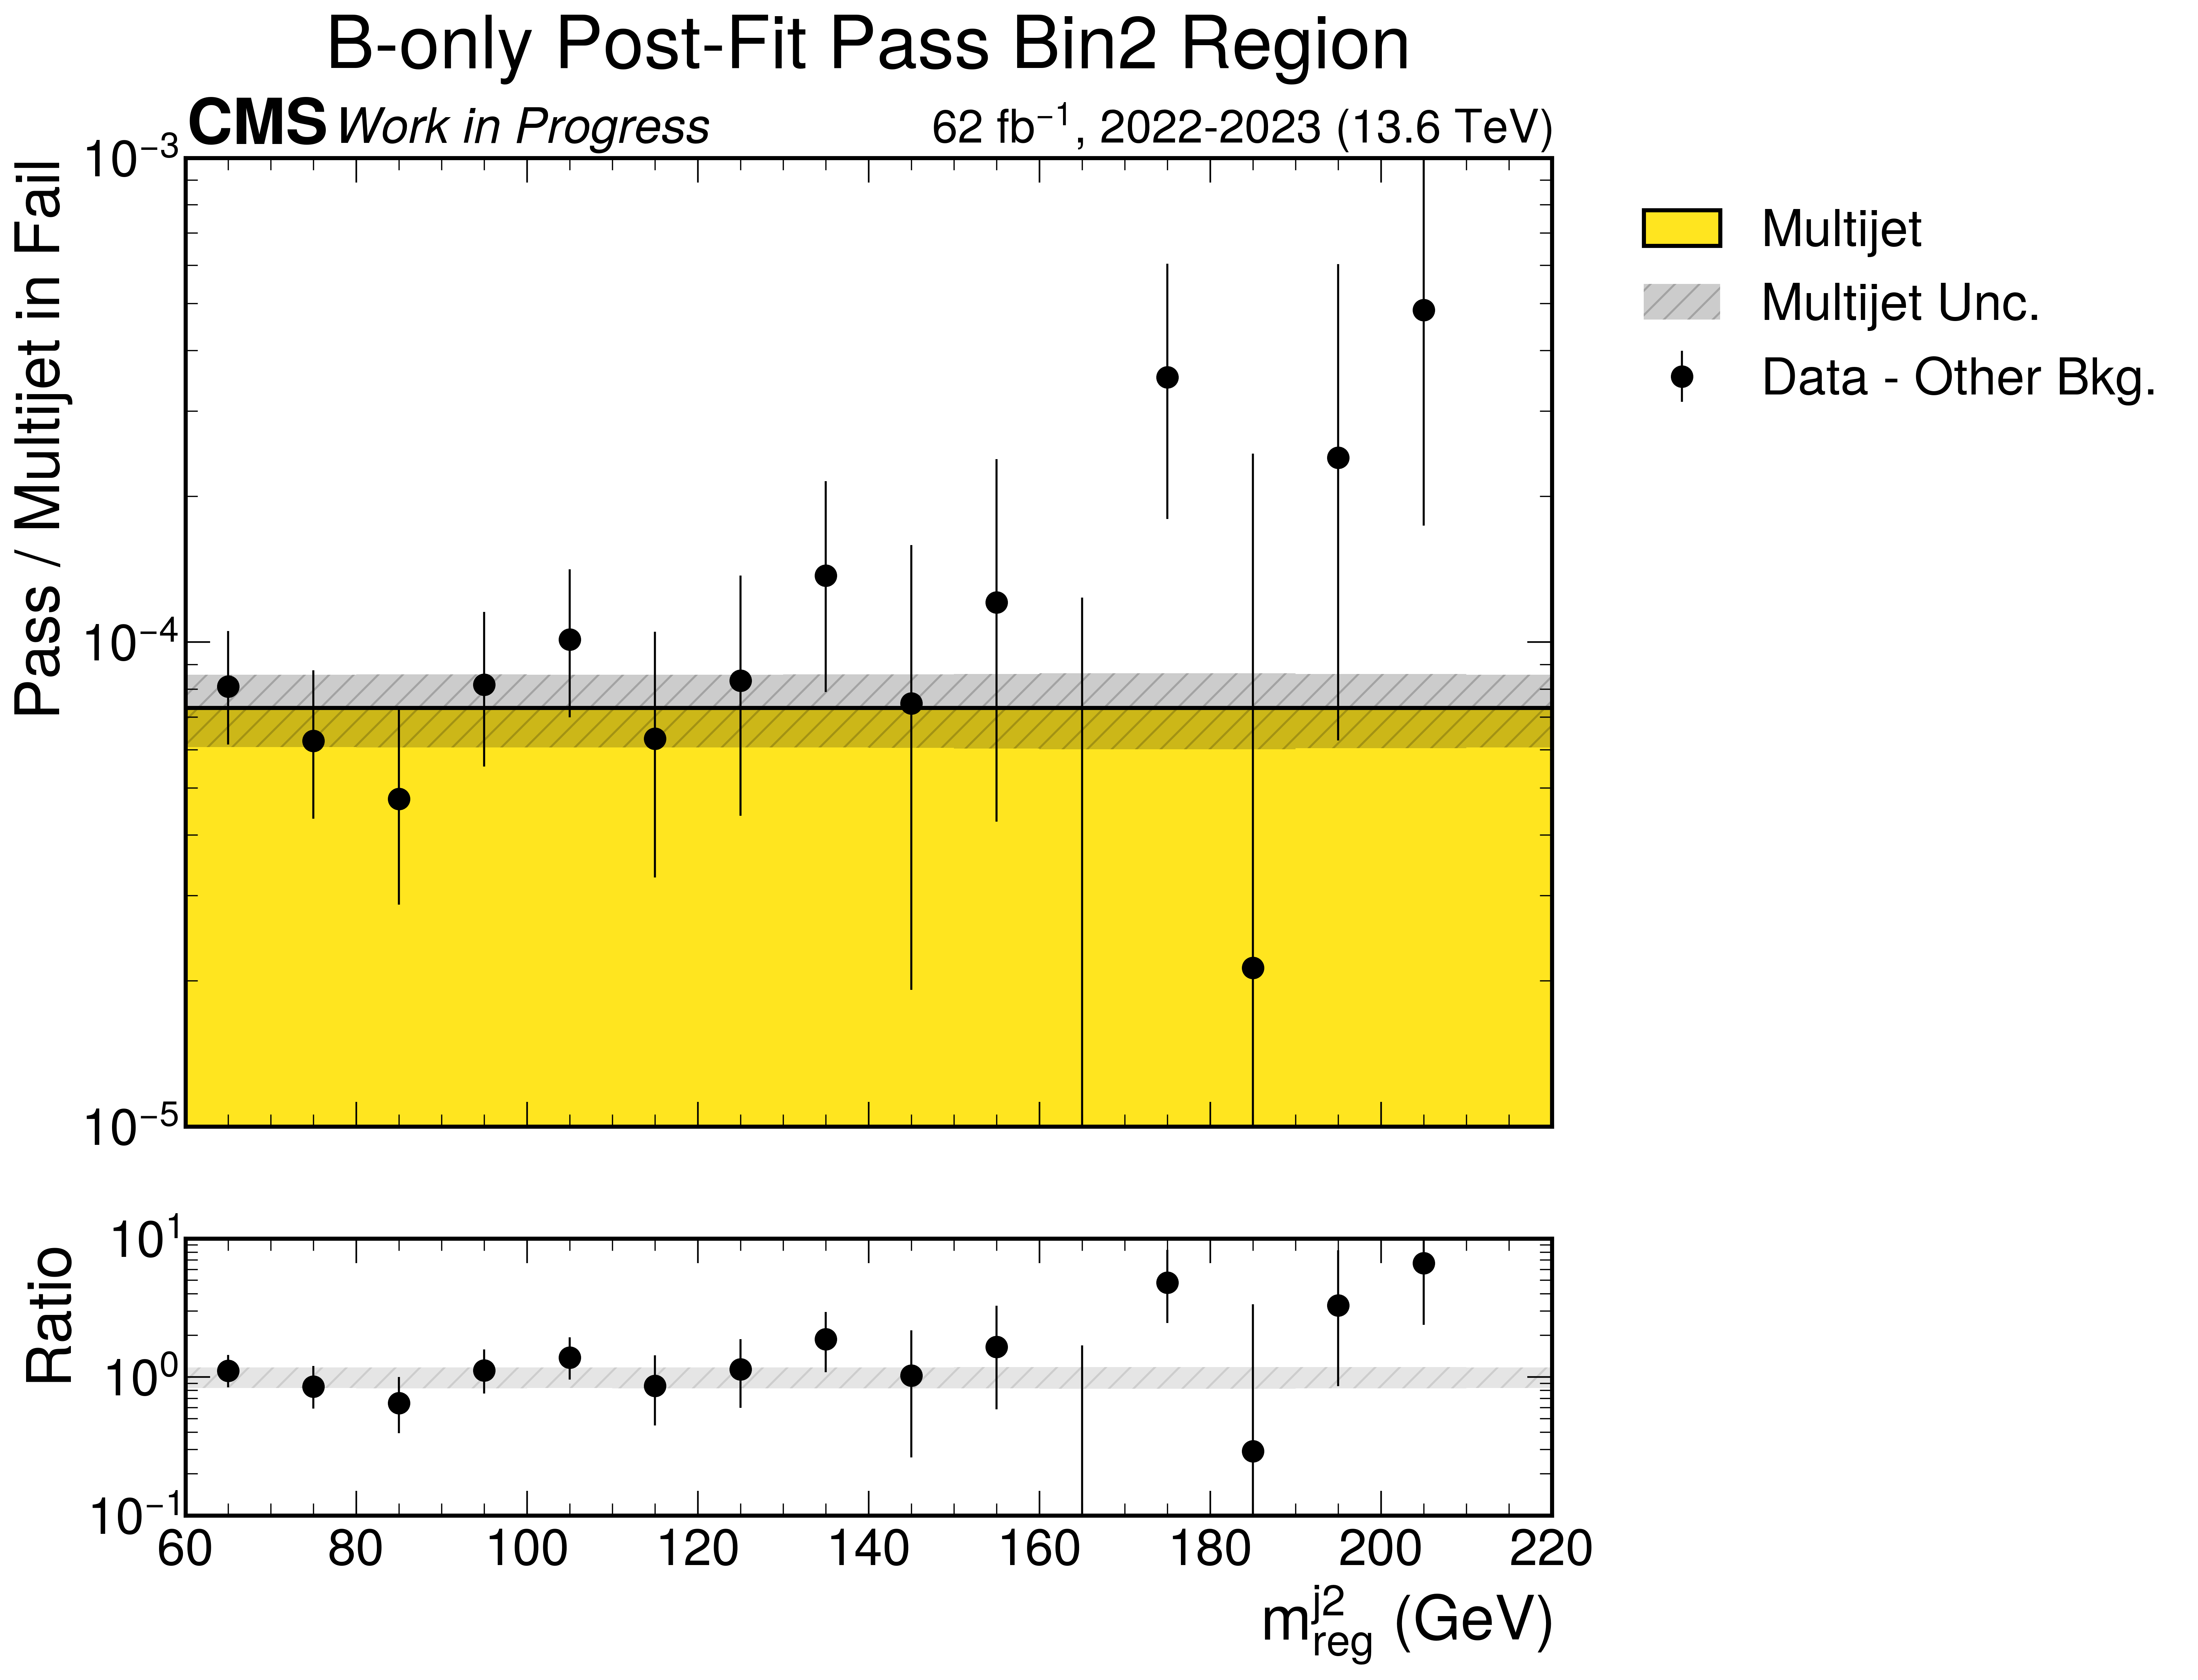

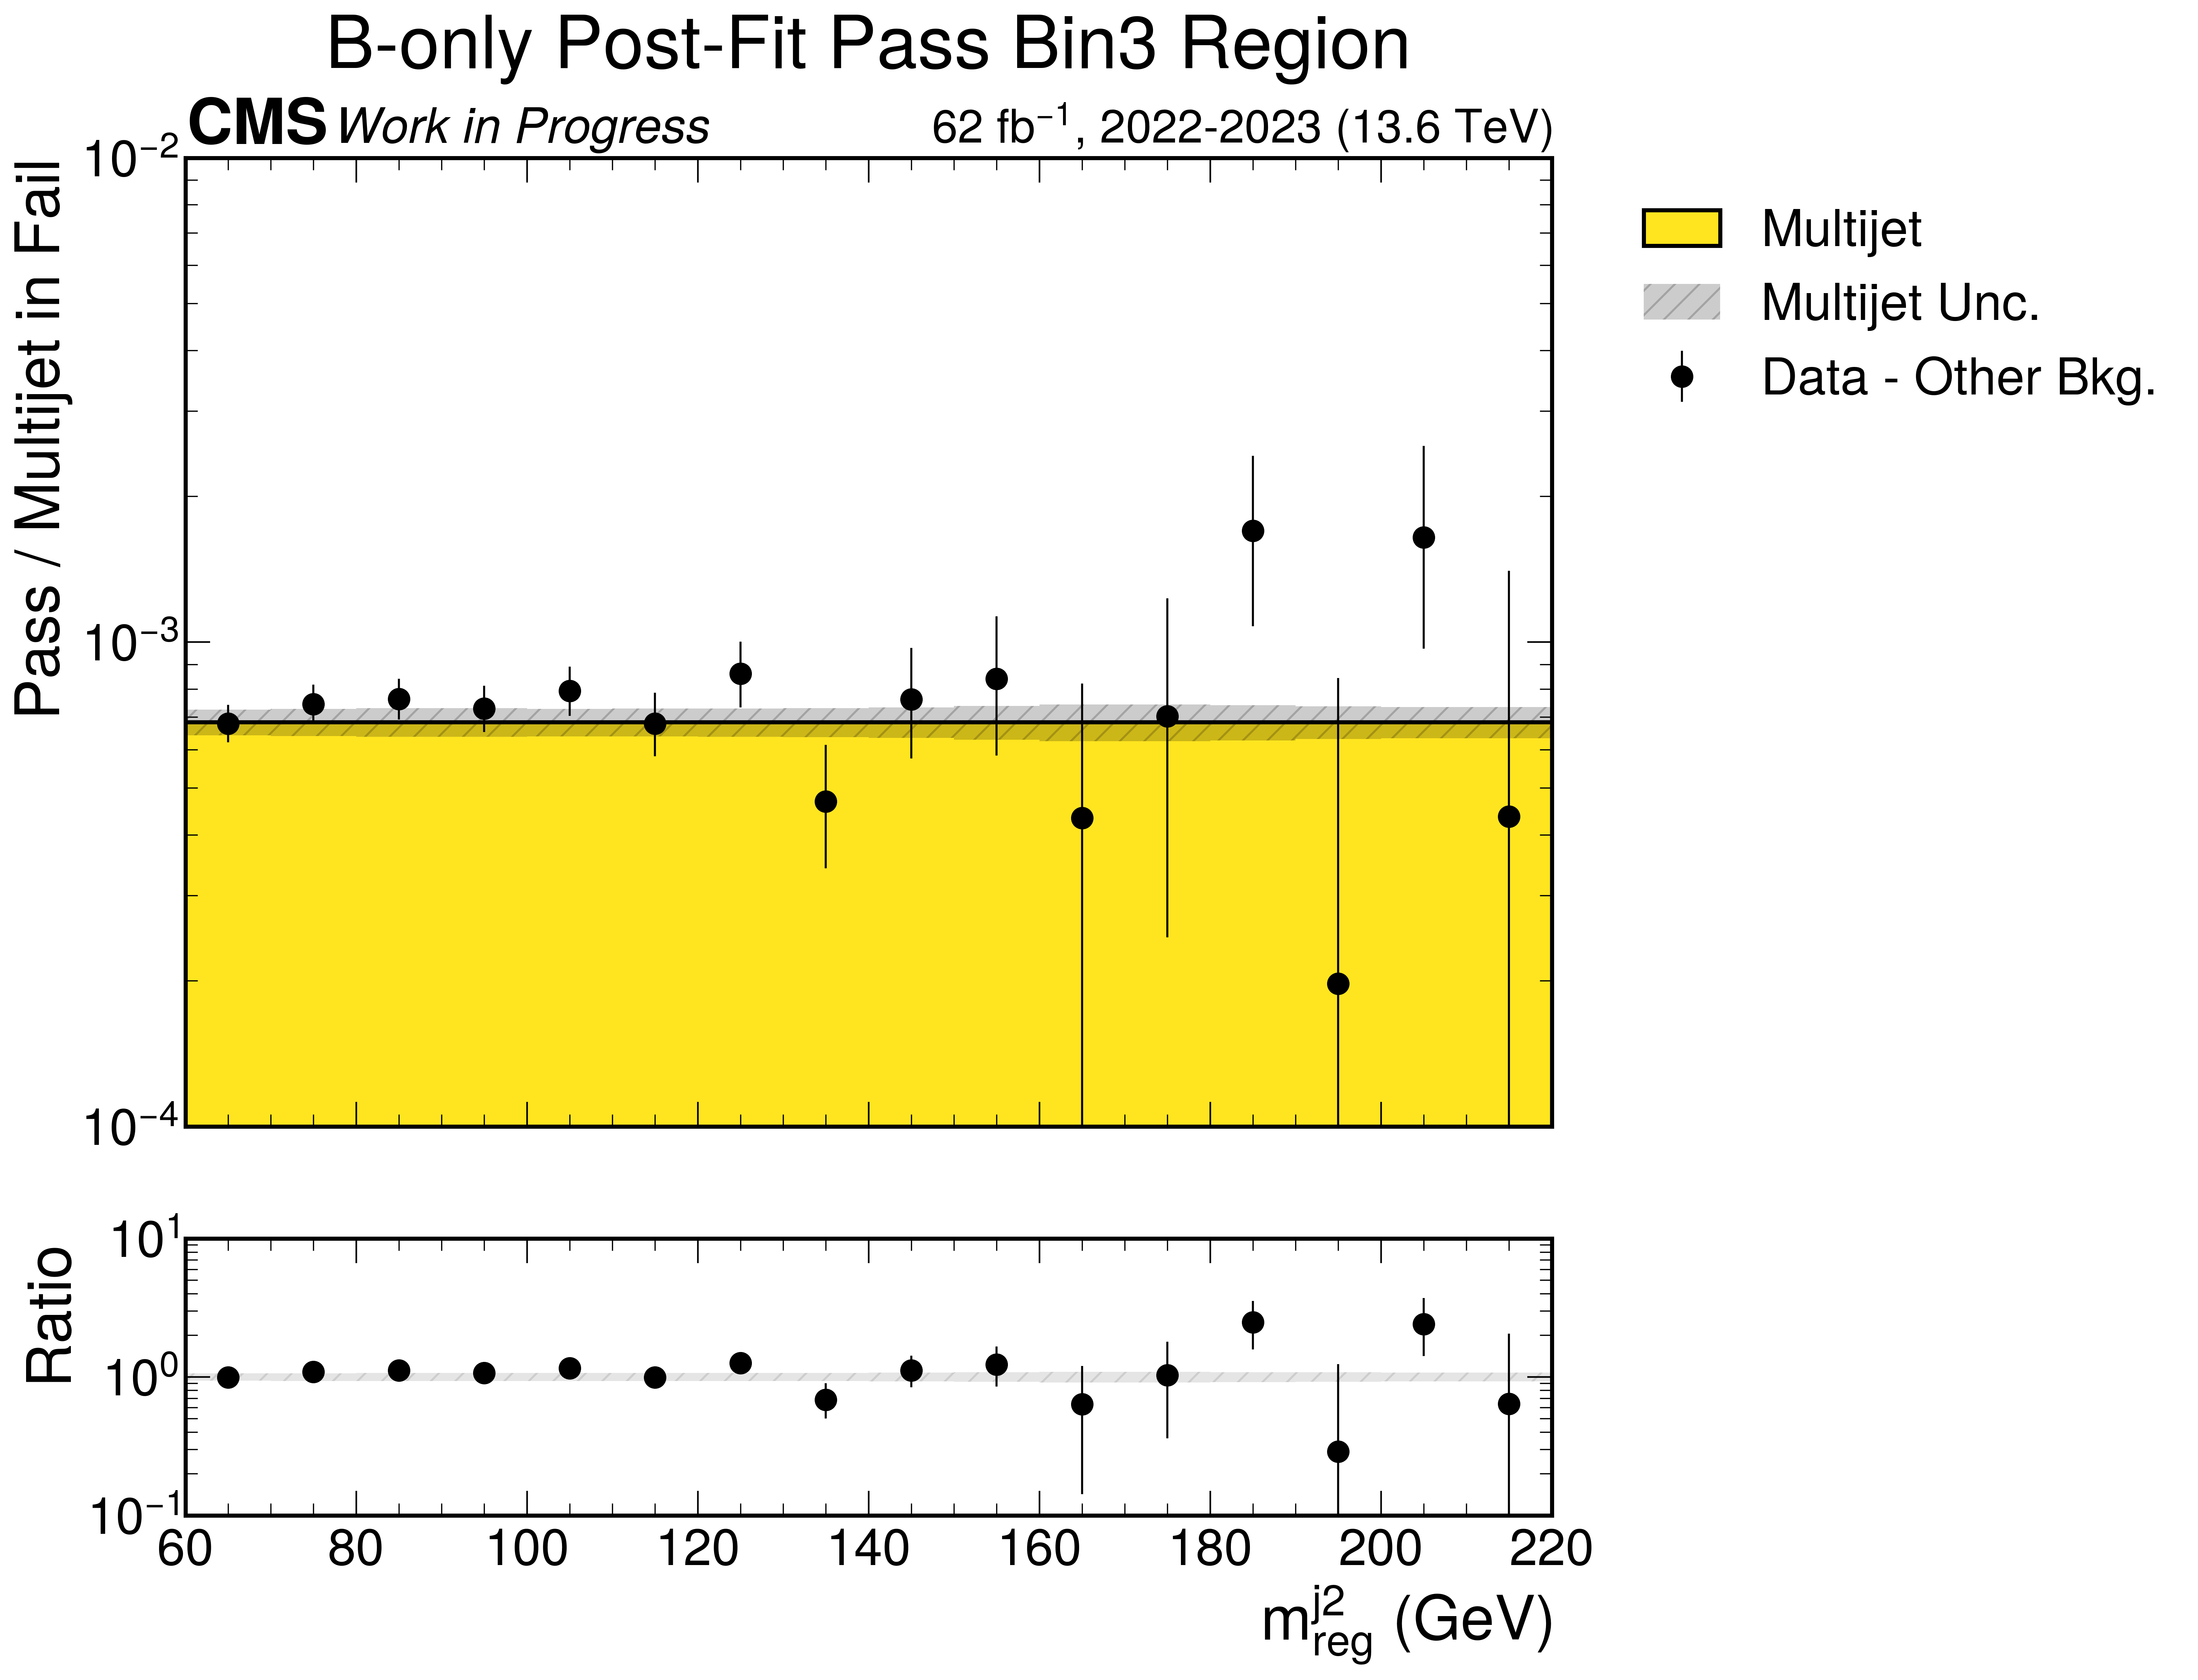

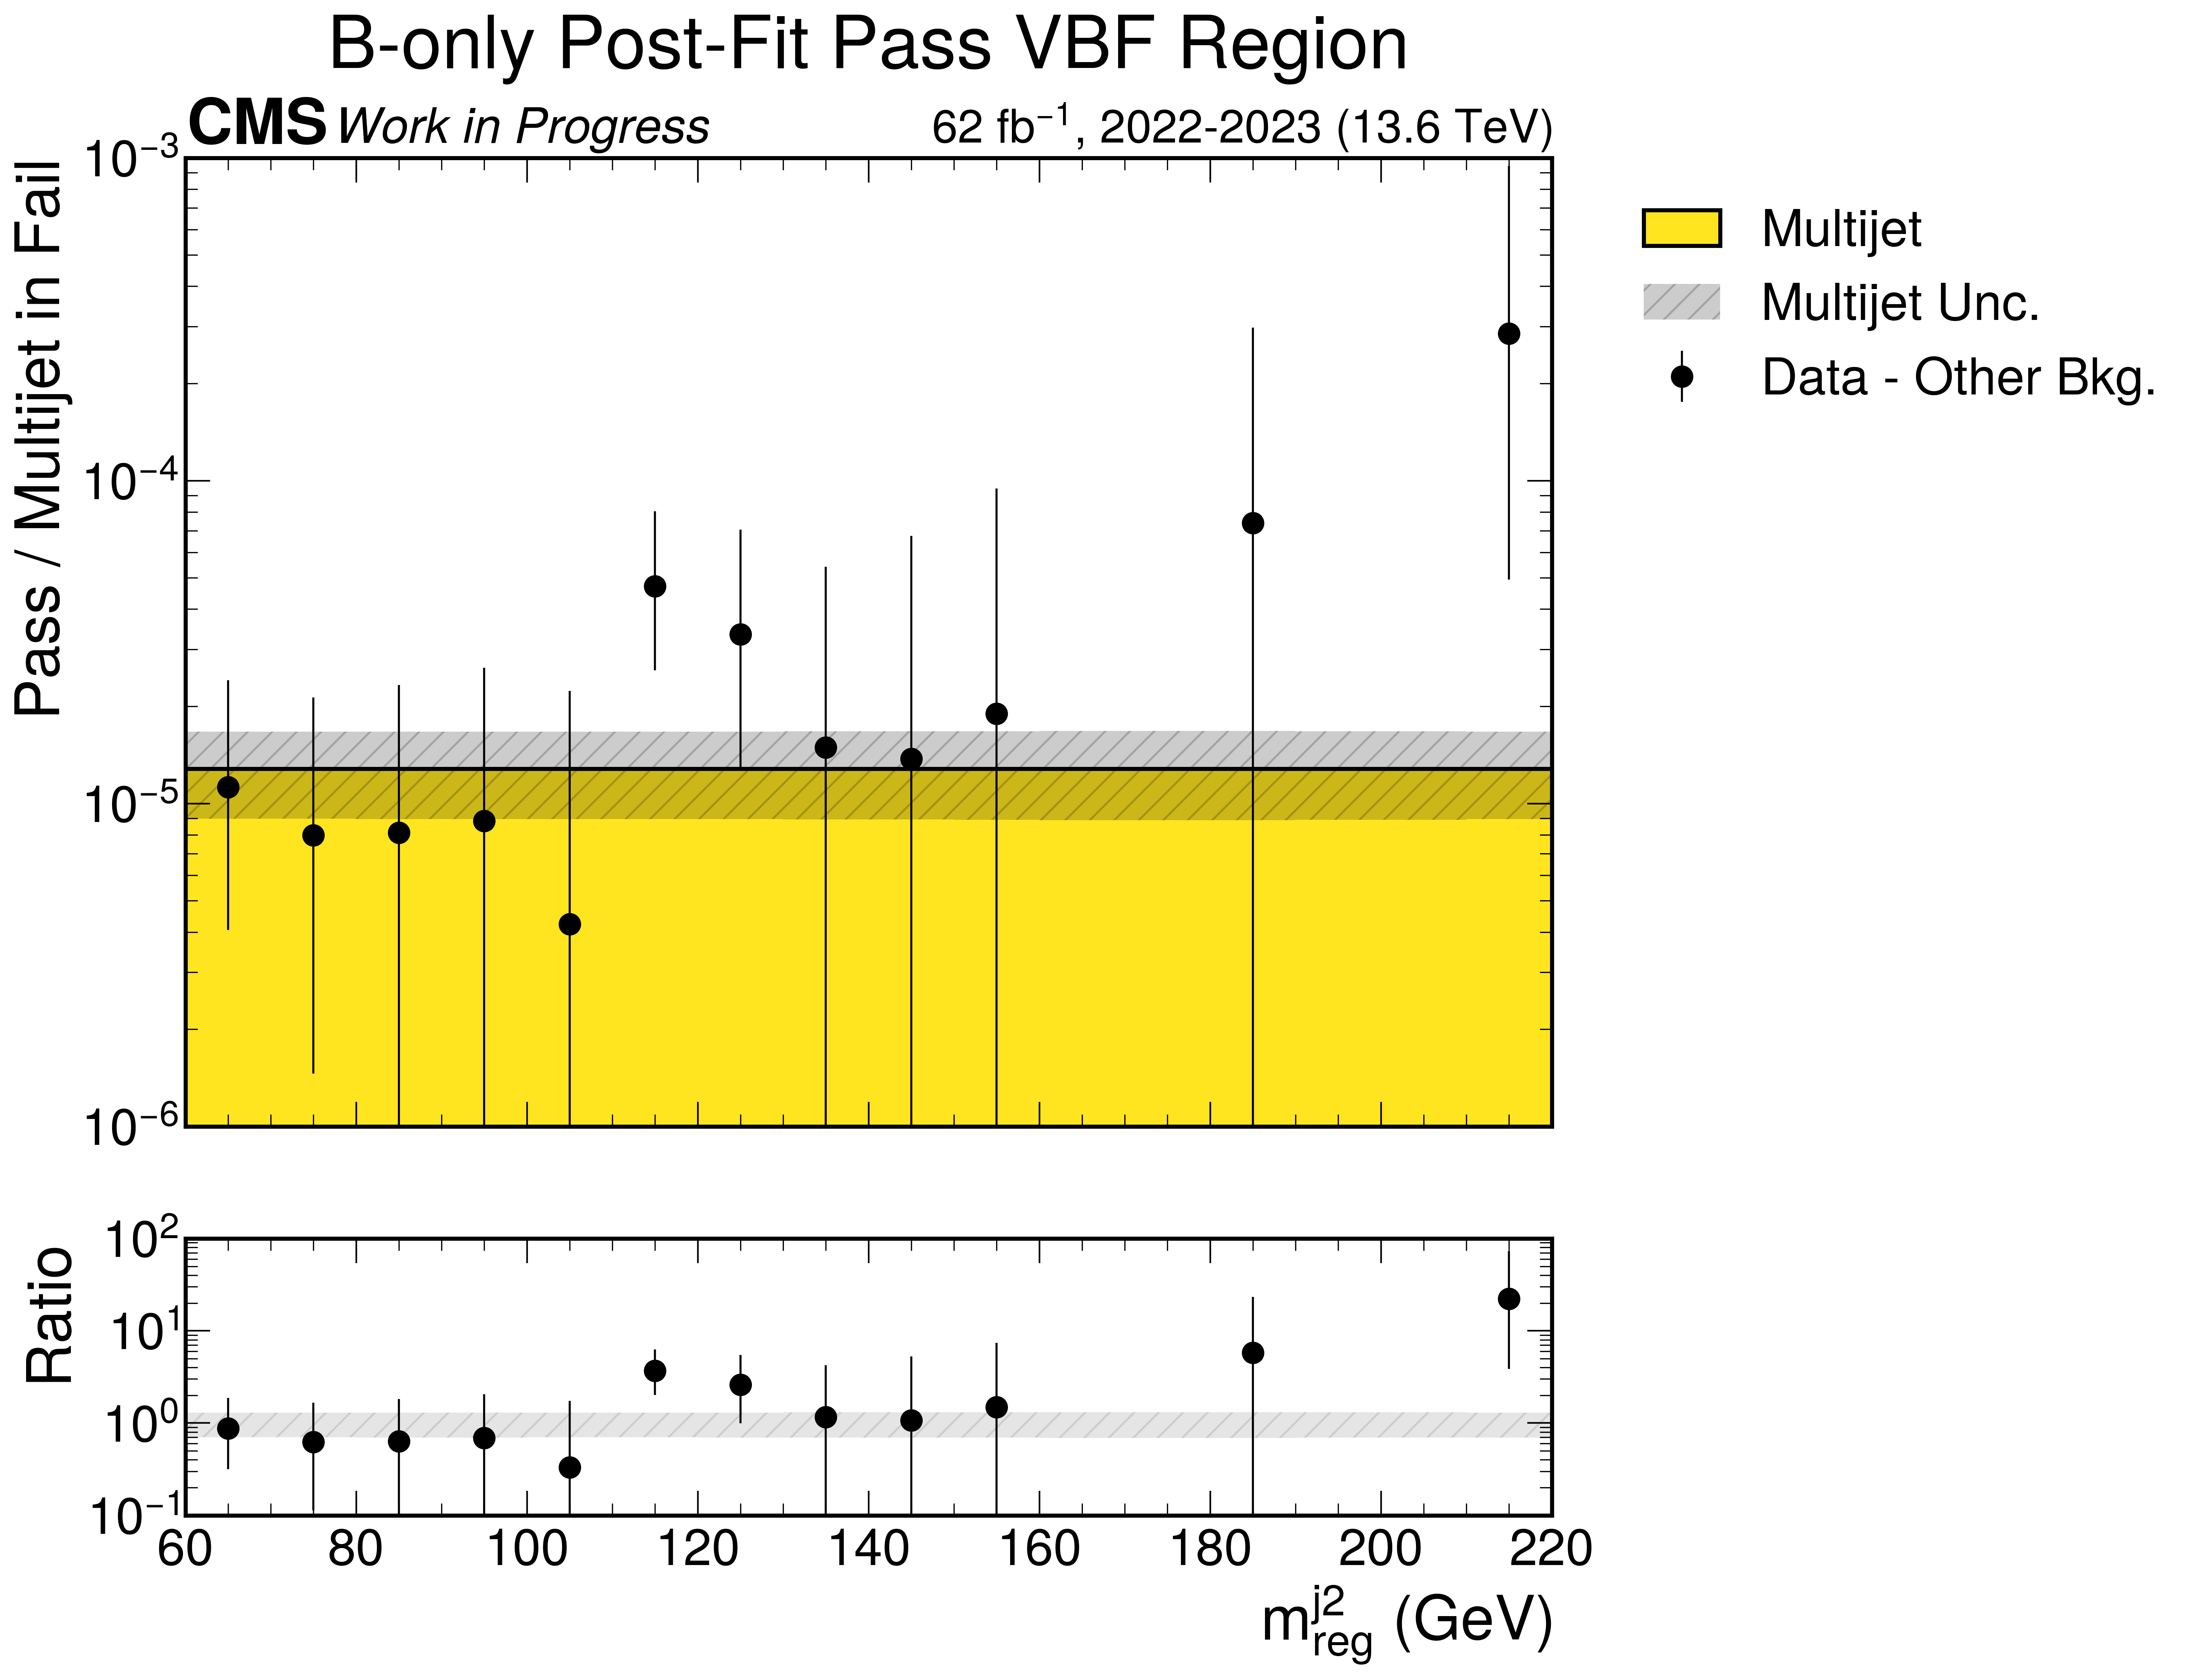

In [25]:
year = "2022-2023"

ratio_ylims = {
    "passvbf": [0.1, 100],
    "passbin1": [0.1, 100],
    "passbin2": [0.1, 10],
    "passbin3": [0.1, 10],
    "fail": [0.1, 10],
}
ylims = {
    "passvbf": 0.001,
    "passbin1": 0.001,
    "passbin2": 0.001,
    "passbin3": 0.01,
    "fail": 1,
}
ylims_low = {
    "passvbf": 0.000001,
    "passbin1": 0.000001,
    "passbin2": 0.00001,
    "passbin3": 0.0001,
    "fail": 0.01,
}

for shape, shape_label in shapes.items():
    for region, region_label in selection_regions.items():
        pass_region = region.startswith("pass")
        if not pass_region:
            continue
        for shape_var in shape_vars:
            plot_params = {
                "hists": hists[shape][region],
                "hists_fail": hists[shape]["fail"],
                "bg_keys": ["qcd", "ttbar", "vhtobb", "tthtobb", "others"],
                "bg_err": bgerrs[shape][region],
                "show": True,
                "year": year,
                "ylim": ylims[region],
                "ylim_low": ylims_low[region],
                "xlim": 220,
                "xlim_low": 60,
                "ratio_ylims": ratio_ylims[region],
                "title": f"{shape_label} {region_label} Region",
                "name": f"{plot_dir}/{shape}_{region}_{shape_var.var}_subtracted.pdf",
                "bg_order": ["diboson", "vjets", "vhtobb", "ttbar", "qcd"],
                "energy": 13.6,
                "log": True,
            }

            plotting.subtractedHistPlot(**plot_params)